# Time series binary classificator using transformer
In this notebook the preprocessed time series data is read and a binary classificator using a transformer is trained to distinguish between the radiation and noise signals.

Reference: https://keras.io/examples/timeseries/timeseries_classification_transformer/

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Load the data

In [2]:
# Load the dataset from the working directory
x_train = np.genfromtxt('./X_train.csv', delimiter=",")
y_train = np.genfromtxt('./y_train.csv', delimiter=",").astype(int)
x_test = np.genfromtxt('./X_test.csv', delimiter=",")
y_test = np.genfromtxt('./y_test.csv', delimiter=",").astype(int)

n_classes = len(np.unique(y_train))

## Visualize the data

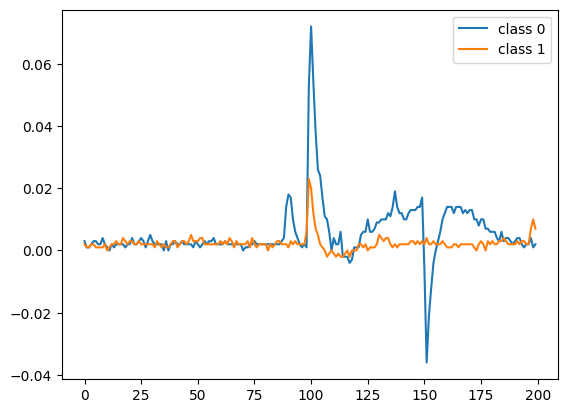

In [3]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Normalize the data

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(np.concatenate((x_train, x_test)))
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## Standardize the data

In [5]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

num_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

## Build the transformer model

In [6]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

## Train the model

In [7]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
            keras.callbacks.ModelCheckpoint("best_model_Transformer.h5", save_best_only=True, monitor="val_loss")
            ]

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 1)]     0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 200, 1)      7169        ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 200, 1)       0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 200, 1)      2           ['dropout[0][0]']            

## Evaluate the model on test data

In [8]:
model = keras.models.load_model("best_model_Transformer.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

5/5 [==============================] - 1s 40ms/step - loss: 0.0755 - sparse_categorical_accuracy: 0.9789
Test accuracy 0.9788732528686523
Test loss 0.07546767592430115


## Plot the model's traing and validation loss

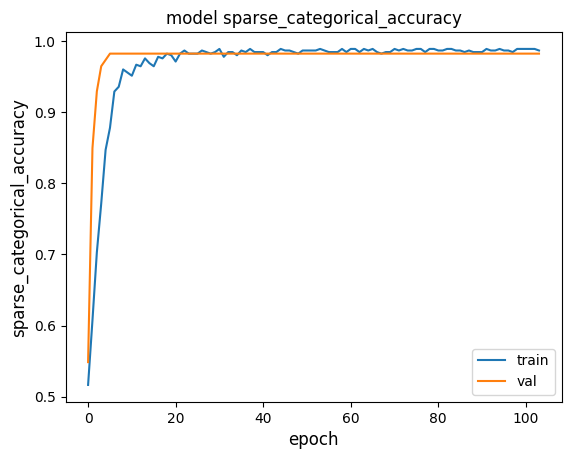

In [9]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

## Confusion matrix for the test data

In [10]:
# Infer the test data
y_pred = model.predict(x_test)
y_pred_binary = y_pred[:, 1] > y_pred[:, 0] # Convert one hot encoding probability array (N,2) to binary vector

# Create the confusion matrix
from sklearn.metrics import confusion_matrix

binary_classification_confusion_matrix = confusion_matrix(y_test, y_pred_binary)
print('Confusion matrix:')
print(binary_classification_confusion_matrix)

5/5 [==============================] - 0s 20ms/step
Confusion matrix:
[[54  1]
 [ 2 85]]
